In [ ]:
@time using Plots
@time using Images
@time using ColorSchemes

 34.496348 seconds (25.97 M allocations: 1.369 GiB, 2.78% gc time)


┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260


## Auxilliary subroutines for SIR simulation

In [2]:
function neighbourIndices(nType::Int64, rad::Int64)
    indices = []
    if(nType == 0)
        indices = vcat([[i, 0] for i in -rad:rad], [[0, j] for j in -rad:rad])
    elseif(nType == 1)
        indices = [[i, j] for i in -rad:rad for j in -rad:rad]
    elseif(nType == 2)
        indices = [[i, j] for j in -rad:rad for i in (abs(j) - rad):(rad - abs(j))]
    end
    
    indices = [CartesianIndex(ind...) for ind in setdiff(indices, [[0,0]])]
end


neighbourIndices (generic function with 1 method)

## Initial Conditions

In [3]:
function setInitConditions(grid, init, tauI, tauR, indices)
    if(init[1] == "random")
        for index in indices
            if(rand() < init[2])
                grid[index] = tauI+1
            end
        end
        grid[init[3], init[4]] = 1
    
    elseif(init[1] == "assorted")
        for index in indices
            if(rand() < init[2])
                grid[index] = 1
            elseif(rand() < init[3])
                grid[index] = tauI+1
            end
        end
        
    elseif(init[1] == "single")
        grid[init[2], init[3]] = 1
        
    elseif(init[1] == "corners")
        grid[rad + 2, rad + 2] = 1
        grid[rad + 2, n - rad - 2] = 1
        grid[n - rad - 2, rad + 2] = 1
        grid[n - rad - 2, n - rad - 2]  = 1
         
    elseif(init[1] == "custom")
        grid[init[2], init[3]] = 1
        grid[init[4], init[5]] = tauI + 1
    end
    
    return
end

setInitConditions (generic function with 1 method)

## Core simulation code

In [3]:
function SIRSmodel(n::Int64, tauI::Int64, tauR::Int64, nType::Int64, rad::Int64, nsteps::Int64, anim::Bool, colbar::Bool, fname, init)
    grid = zeros(Int64, (n, n)) #2D grid
    nData = zeros(Int64, (nsteps, 3)) #S,I,R count
    frames = [] #to store grid for display
    
    infp = 0 #infection probability
    tau0 = tauR + tauI #complete disease cycle 
    relNeighbour = neighbourIndices(nType, rad) #relative index of neighbours
    isInfected(x) = 1 <= x <= tauI #infected check
    indices = [CartesianIndex(i,j) for i in (rad+1):(n-rad) for j in (rad+1):(n-rad)]

    #initial conditions
    setInitConditions(grid, init, tauI, tauR, indices)
    
    #boundary conditions; fixed
    grid[1:rad, :] .= tauI + 1
    grid[(n-rad+1):n, :] .= tauI + 1
    grid[:, 1:rad] .= tauI + 1
    grid[:, (n-rad+1):n] .= tauI + 1   
    
    prev = copy(grid) #copy of the grid
    push!(frames, copy(grid))
    
    #initial count
    nData[1, 1] = count(x -> x==0, grid)
    nData[1, 2] = count(x -> 1 <= x <= tauI, grid)
    nData[1, 3] = count(x -> tauI < x <= tau0, grid)
    
    for k in 2:nsteps
        nData[k, :] = nData[k-1, :]
        
        for index in indices
            if(prev[index] == 0) #susceptible
                infp = count(isInfected.(prev[relNeighbour .|> x-> index+x]))/length(relNeighbour)
                
                if(0<infp) #infection
                    grid[index] += 1
                    nData[k, 1] -= 1
                    nData[k, 2] += 1
                end
                
            elseif(prev[index] < tau0) #infected/refractory
                grid[index] += 1
                
                if(grid[index] == tauI + 1) #transition to R
                    nData[k, 2] -= 1
                    nData[k, 3] += 1
                end
            
            elseif(prev[index] == tau0) #transition to S
                grid[index] = 0
                nData[k, 3] -= 1
                nData[k, 1] += 1
            end
        end
        
        prev = copy(grid)
        push!(frames, copy(grid))
    end
    
    #color gradient
    colors = vcat([RGB{N0f8}(0, 0, 0)], range(RGB{N0f8}(0.5,0.0,0.0), stop=RGB{N0f8}(0.862,0,0), length= tauI),range(RGB{N0f8}(1,0.458,0.0), stop=RGB{N0f8}(1, 1, 0.196), length=tauR))
    
    if(colbar) #with colorbar
        animGIF = @animate for i = 1:nsteps 
            heatmap(frames[i], c = palette(colors, tau0+1), clim = (0, tau0))
        end
        
    else #without colorbar
        cmap = Dict(zip(0:tau0+1, colors))
        animGIF = @animate for i = 1:nsteps 
            plot([cmap[p] for p in frames[i]])
        end
    end
        
    gif(animGIF, fname, fps = 15)
    
    return nData
end     
    

LoadError: UndefVarError: @animate not defined

In [14]:
#function SIRSmodel(n, tauI, tauR, nType, rad, nsteps, anim, colorbar, init)
nsteps = 100
s = 200
num = 3
@time data = SIRSmodel(s, 5, 10, 1, num, nsteps, true, true, "outputs/1SIRS"*string(num)*".gif", ["single", s÷2, s÷2])
x = 1:nsteps
plot(x, data, label = ["Susceptible" "Infected" "Refractory"], lw = 2, grid = true)
savefig("outputs/plot1"*string(num)*".png")

 27.714433 seconds (128.08 M allocations: 7.329 GiB, 4.88% gc time)


┌ Info: Saved animation to 
│   fn = /home/akshay/code-repo/ComplexSystems/outputs/1SIRS3.gif
└ @ Plots /home/akshay/.julia/packages/Plots/uCh2y/src/animation.jl:104


## Collect data version

In [4]:
function SIRSmodelCollect(n::Int64, tauI::Int64, tauR::Int64, pImmune::Float64, nType::Int64, rad::Int64, nsteps::Int64, anim::Bool, colbar::Bool, fname, init)
    grid = zeros(Int64, (n + 2*rad, n + 2*rad)) #2D grid
    nData = zeros(Int64, (nsteps, 4)) #S,I,R count
    frames = [] #to store grid for display
    nTime = 1 #notes number of time steps passed
    
    infp = 0 #infection probability
    tau0 = tauR + tauI #complete disease cycle 
    isInfected(x) = 1 <= x <= tauI #infected check
    
    relNeighbour = neighbourIndices(nType, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)]
    
    #initial conditions
    setInitConditions(grid, init, tauI, tauR, indices)
    
    #boundary conditions; fixed
    grid[1:rad, :] .= tauI + 1
    grid[(n+rad+1):(n+2*rad), :] .= tauI + 1
    grid[:, 1:rad] .= tauI + 1
    grid[:, (n+rad+1):(n+2*rad)] .= tauI + 1   
    
    prev = copy(grid) #copy of the grid
    push!(frames, copy(grid))
    
    #initial count
    nData[1, 1] = count(x -> x==0, grid)
    nData[1, 2] = count(x -> 1 <= x <= tauI, grid[indices])
    nData[1, 3] = count(x -> tauI < x <= tau0, grid[indices])
    nData[1, 4] = count(x -> tau0 < x, grid[indices])
    
    for k in 2:nsteps
        nData[k, :] = nData[k-1, :]
        
        for index in indices
            if(prev[index] == 0) #susceptible
                infp = count(isInfected.(prev[relNeighbour .|> x-> index+x]))/length(relNeighbour)
                
                if(rand()<infp) #infection
                    grid[index] += 1
                    nData[k, 1] -= 1
                    nData[k, 2] += 1
                end
                
            elseif(prev[index] < tau0) #infected/refractory
                grid[index] += 1
                
                if(grid[index] == tauI + 1) #transition to R
                    nData[k, 2] -= 1
                    nData[k, 3] += 1
                end
            
            elseif(prev[index] == tau0) #transition to S
                nData[k, 3] -= 1
                
                if(rand() < pImmune)
                    grid[index] += 1
                    nData[k, 4] += 1
                else 
                    grid[index] = 0
                    nData[k, 1] += 1
                end
                    
            end
        end
        
        nTime += 1
        prev = copy(grid)
        push!(frames, copy(grid))
        
        if(nData[k, 2] == 0 && nData[k, 3] == 0) break end
        
    end
    
    #color gradient
    colors = vcat([RGB{N0f8}(0, 0, 0)], range(RGB{N0f8}(0.5,0.0,0.0), stop=RGB{N0f8}(0.862,0,0), length= tauI),range(RGB{N0f8}(1,0.458,0.0), stop=RGB{N0f8}(1, 1, 0.196), length=tauR), [RGB{N0f8}(0.411,0.411,0.411)])
    
    if(colbar && anim) #with colorbar
        animGIF = @animate for i = 1:nTime 
            heatmap(frames[i], c = palette(colors, tau0+1), clim = (0, tau0))
        end
        gif(animGIF, fname, fps = 15)
        
    elseif(anim) #without colorbar
        cmap = Dict(zip(0:tau0+1, colors))
        animGIF = @animate for i = 1:nTime
            plot([cmap[p] for p in frames[i]])
        end
        gif(animGIF, fname, fps = 15)
    end
    
    nData[nTime+1:end, 1] .= nData[nTime, 1]
    nData[nTime+1:end, 4] .= nData[nTime, 4]
    
    return [nData, nTime]
end     

SIRSmodelCollect (generic function with 1 method)

In [29]:
#function SIRSmodel(n, tauI, tauR, nType, rad, nsteps, anim, colorbar, init)
nsteps = 300
s = 200
num = 2
@time data, nn = SIRSmodelCollect(s, 5, 10, 0.1, 1, num, nsteps, true, false, "outputs/1SIRS"*string(num)*".gif", ["single", s÷2, s÷2])
x = 1:nsteps
plot(x, data, label = ["Susceptible" "Infected" "Refractory"], lw = 2, grid = true)
savefig("outputs/plot1"*string(num)*".png")

 36.970259 seconds (96.63 M allocations: 7.208 GiB, 5.52% gc time)


┌ Info: Saved animation to 
│   fn = /home/akshay/code-repo/ComplexSystems/outputs/1SIRS2.gif
└ @ Plots /home/akshay/.julia/packages/Plots/uCh2y/src/animation.jl:104


## Analysis code

In [5]:
#function SIRSmodel(n, tauI, tauR, nType, rad, nsteps, anim, colorbar, init)
nsteps = 600
s = 100
num = 2 #radius
ntype = 1
taui = 5
taur = 10
pimmune = 0.1
xAx = 1:nsteps
listtt = []
final = []
for ll in 0.1:0.05:1.0
    listtt = []
    pimmune = ll
    
    @time for l in 1:5
        data, nT = SIRSmodelCollect(s, taui, taur, pimmune, ntype, num, nsteps, false, false, "outputs2/"*string(taui)*"+"*string(taur)*"_SIRS_"*string(ntype)*"_"*string(num)*"->"*string(pimmune)*"%.gif", ["single", s-2 + num, s-2 + num])
        plot(xAx, data ./ s^2, label = ["Susceptible" "Infected" "Refractory" "Immune"], lw = 2, grid = true)
        savefig("outputs2/"*string(taui)*"+"*string(taur)*"_plot_"*string(ntype)*"_"*string(num)*"->"*string(pimmune)*"%.png")
        if(data[nsteps,4] > 0) push!(listtt, data[nsteps,4]/s^2 *100) end
    end
    push!(final, listtt)
end

 55.263190 seconds (196.84 M allocations: 14.368 GiB, 5.18% gc time)
 23.399043 seconds (143.62 M allocations: 11.068 GiB, 7.32% gc time)
 20.630530 seconds (124.52 M allocations: 9.586 GiB, 8.01% gc time)
 17.835924 seconds (116.50 M allocations: 8.950 GiB, 7.02% gc time)
 19.518312 seconds (110.68 M allocations: 8.501 GiB, 7.31% gc time)
 19.662778 seconds (117.48 M allocations: 9.020 GiB, 8.19% gc time)
 19.491966 seconds (113.52 M allocations: 8.713 GiB, 7.25% gc time)
 18.311775 seconds (93.96 M allocations: 7.212 GiB, 7.66% gc time)
 13.261783 seconds (78.26 M allocations: 5.989 GiB, 7.97% gc time)
 17.701469 seconds (109.62 M allocations: 8.404 GiB, 6.97% gc time)
 13.278202 seconds (83.36 M allocations: 6.372 GiB, 7.73% gc time)
 10.321395 seconds (72.78 M allocations: 5.560 GiB, 5.84% gc time)
 11.049046 seconds (66.53 M allocations: 5.080 GiB, 7.77% gc time)
  8.948119 seconds (53.71 M allocations: 4.102 GiB, 6.27% gc time)
  9.595409 seconds (62.80 M allocations: 4.802 GiB, 

In [6]:
using Statistics

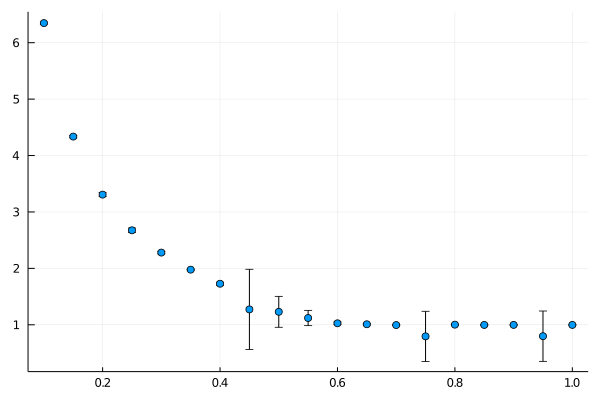

In [10]:
prob = collect(0.1:0.05:1.0)
ff = final ./ (prob .* 100)
imm = [Statistics.mean(a) for a in ff]
imm_err = [Statistics.std(a) for a in ff]
scatter(prob, imm, yerr = imm_err,lw = 2, grid = true, legend = false)